# Cadence Feature Extraction Pipeline

# Packages and Config

In [1]:
import sys
import random
import pandas as pd
import os
import pathlib
import yaml
import disvoice
import librosa 
import numpy as np
import soundfile as sf
import matplotlib.pyplot as plt
import scipy.stats as stats
from numpy import diff

import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

from pydub import AudioSegment, silence
from pydub.playback import play

# Configure display and plotting options
pd.set_option('display.max_rows', None)
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 12}
plt.rc('font', **font)

# Set WD
try:
    os.chdir('cadence_modelling/')
except:
    print(f'WD: {os.getcwd()}')

# Import configs
with open('/home/ubuntu/configs/config.yaml', 'r') as file:
    inputs = yaml.safe_load(file)

/home/ubuntu/.local/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
################################################################################
### WARNING, path does not exist: KALDI_ROOT=/mnt/matylda5/iveselyk/Tools/kaldi-trunk
###          (please add 'export KALDI_ROOT=<your_path>' in your $HOME/.profile)
###          (or run as: KALDI_ROOT=<your_path> python <your_script>.py)
################################################################################



WD: /home/ubuntu/testing-code/cadence-modellling


# Ingestion of files

In [2]:
# Begin with list of files; here we use an example template while we await the full class ouput
def extract_input_files(data_input_path):

    all_wav_files = pathlib.Path(data_input_path)
    all_wav_files = list(all_wav_files.rglob("*.wav")) + list(all_wav_files.rglob("*.WAV"))
    all_wav_files = [str(file) for file in all_wav_files]

    #real_resampled_wav_files = [file for file in all_wav_files if 'TIMIT converted' in file]
    #fake_resampled_wav_files = [file for file in all_wav_files if not 'TIMIT converted' in file]

    flags = [1 if 'TIMIT converted' in str(item) else 0 for item in all_wav_files]
    
    return all_wav_files, flags #real_resampled_wav_files, fake_resampled_wav_files, flags

all_wav_files, flags = extract_input_files('../../data/TIMIT-fake')

# 1. Set thresholds

In [3]:
silence_threshold = 0.005 # 0.5 percent (0.005), from '0_cadence_modelling.ipynb'. Previously we used 0.2% in the truncation step.
low_pass_filter_cutoff = 10 # from '1_cadence_LJ.ipynb'

# Balance data

In [4]:
# NEED TO CHECK THIS - does it do it by architecture?
def balance_data(all_wav_files):
    
    folders = set([all_wav_files[i].split('_')[-1].split('.')[0] for i in range(len(all_wav_files))])
    
    real_resampled_wav_files = [file for file in all_wav_files if 'TIMIT converted' in file]
    fake_resampled_wav_files = [file for file in all_wav_files if not 'TIMIT converted' in file]
    
    # Ensure we take the same number of each phrase for real and fake, downsample the fake files 
    balanced_real_resampled_wav_files = []
    balanced_fake_resampled_wav_files = []
    
    for folder in folders:
        real_examples = [file for file in real_resampled_wav_files if f'_{folder}.' in file]
        fake_examples = [file for file in fake_resampled_wav_files if f'_{folder}.' in file]

        if len(real_examples) > len(fake_examples):
            real_examples = random.sample(real_examples, len(fake_examples))
        else:
            fake_examples = random.sample(fake_examples, len(real_examples))

        [balanced_real_resampled_wav_files.append(file) for file in real_examples]
        [balanced_fake_resampled_wav_files.append(file) for file in fake_examples]
    
    rebalanced_wav_files = balanced_real_resampled_wav_files + balanced_fake_resampled_wav_files
    rebalanced_flags = [i for i in np.zeros(len(balanced_real_resampled_wav_files))] + [i for i in np.ones(len(balanced_fake_resampled_wav_files))] 
    
    return rebalanced_wav_files, rebalanced_flags

rebalanced_wav_files, rebalanced_flags = balance_data(all_wav_files)

# Quick test
#print(len(balanced_real_resampled_wav_files), len(balanced_fake_resampled_wav_files))

#folders = set([real_resampled_wav_files[i].split('_')[-1].split('.')[0] for i in range(len(real_resampled_wav_files))])

#for folder in folders:
#    real_fols = [item for item in balanced_real_resampled_wav_files if item.lower().endswith(f'{folder.lower()}.wav')]
#    fake_fols = [item for item in balanced_fake_resampled_wav_files if item.lower().endswith(f'{folder.lower()}.wav')]
#    if len(real_fols) != len(fake_fols):
#           print(len(real_fols), len(fake_fols))

# 2. Normalise amplitudes

In [5]:
def normalize_audio_amplitudes(all_wav_files):
    normalized_audios = []
    
    for file in all_wav_files:
        sample = librosa.load(file)[0]
        max_abs = np.max(np.abs(sample))
        normalized_sample = sample/max_abs
        normalized_audios.append(normalized_sample)
        
    return normalized_audios

In [ ]:
normalized_audios = normalize_audio_amplitudes(all_wav_files)

# Perform check
i = 0
plt.grid()
plt.plot(np.arange(len(normalized_audios[i])), normalized_audios[i])
plt.title(f"")
plt.show()

# 3. Truncate silences at start and end of clip

In [6]:
def truncate_silences(normalized_audios, silence_threshold, window_size=100, counter=0):
    truncated_audios = []
    start_ids = []
    end_ids = []
    
    for audio in normalized_audios:
        counter += 1
        if counter % 100 == 0:
            print(f'Truncating audio {counter}/{len(normalized_audios)} ({round(counter*100/len(normalized_audios))}%)')

        for j in range(len(audio)):
            roll_average = np.mean(np.abs(audio[j:j+window_size]))
            if roll_average > silence_threshold:
                truncation_id_start = j
                break

        for j in reversed(range(len(audio))):
            roll_average = np.mean(np.abs(audio[j-window_size:j]))
            if roll_average > silence_threshold:
                truncation_id_end = j-window_size
                break
        truncated_audios.append(audio[truncation_id_start:truncation_id_end])
        start_ids.append(truncation_id_start)
        end_ids.append(truncation_id_end)
    
    return truncated_audios, start_ids, end_ids

#truncated_audios, start_ids, end_ids = truncate_silences(normalized_audios, silence_threshold, window_size=100)

In [ ]:
# Test
#j = 9770
#i = 9782

#for item in np.arange(j, i):
#    print(item)
#    plt.grid()
#    plt.plot(np.arange(len(normalized_audios[item])), normalized_audios[item])
#    plt.title(f"")
#    plt.axvline(x=start_ids[item], color='r', linestyle='-')
#    plt.axvline(x=end_ids[item], color='r', linestyle='-')
#    plt.plot(np.arange(len(truncated_audios[item])), truncated_audios[item])
#    plt.show()

# 4. Features: Pause Extraction

In [7]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

def get_silence(audio, percent, sample_rate=None, cutoff_frequency=None):
    thresh = max(abs(audio))*percent
    
    moving_avg = moving_average(abs(audio), 100)

    silent = np.where(abs(moving_avg) < thresh)
    voiced = np.where(abs(moving_avg) >= thresh)
    
    pct_pause = len(silent[0])*100/(len(silent[0])+len(voiced[0]))
    pct_voiced = len(voiced[0])*100/(len(silent[0])+len(voiced[0]))
    ratio_pause_voiced = len(silent[0])/len(voiced[0]) 

    return {'pct_pause':pct_pause, 'pct_voiced': pct_voiced, 'ratio_pause_voiced': ratio_pause_voiced}

def get_silence_spread(audio, percent, sample_rate=None, cutoff_frequency=None):

    thresh = max(abs(audio))*percent
    
    moving_avg = moving_average(abs(audio), 100)

    silent_windows = np.where(moving_avg < thresh)
    moving_avg[silent_windows] = 0
    silence_count = 0
    silence_counts = []
    
    for i in range(len(moving_avg)-1):
        item = moving_avg[i]
        next_item = moving_avg[i+1]
        
        if item != 0 and next_item == 0:
            silence_count = 0
            
        elif item == 0 and next_item == 0:
            silence_count += 1
            
        elif item == 0 and next_item != 0:
            silence_counts.append(silence_count)
        
        else:
            continue  
    
    # Get spreads/means and normalise
    spread_of_silences = np.std(silence_counts)/len(moving_avg)
    mean_of_silences = np.mean(silence_counts)/len(moving_avg)
    n_pauses = len(silence_counts)
        
    return {'spread_of_silences':spread_of_silences, 'mean_of_silences':mean_of_silences, 'silence_counts':silence_counts, 'n_pauses':n_pauses}


In [8]:
def run_all_files(truncated_audios, flags, function, percent, sample_rate=None, cutoff_frequency=None):
    # Instantiate results - r=real, f=fake
    r_results = []
    f_results = []

    real_indices = np.array([int(i) for i in range(len(flags)) if flags[i] == 0])
    fake_indices = np.array([int(i) for i in range(len(flags)) if flags[i] != 0])
    
    real_examples = [truncated_audios[i] for i in real_indices]
    fake_examples = [truncated_audios[i] for i in fake_indices]

    for item in real_examples:
        r_result = function(item, percent, sample_rate, cutoff_frequency)
        r_results.append(r_result)

    for item in fake_examples:
        f_result = function(item, percent, sample_rate, cutoff_frequency)
        f_results.append(f_result)
    
    return r_results, f_results

#r_results, f_results = run_all_files(truncated_audios, rebalanced_flags, get_silence, silence_threshold)

In [ ]:
r_pauses, f_pauses = run_all_files(truncated_audios, rebalanced_flags, get_silence, silence_threshold)
r_silence_spreads, f_silence_spreads = run_all_files(truncated_audios, rebalanced_flags, get_silence_spread, silence_threshold)

# Amplitude 

In [11]:
def filter_signal(audio, sample_rate, cutoff_frequency):
    t = np.arange(len(audio)) / sample_rate 
    w = cutoff_frequency / (sample_rate / 2) 
    b, a = signal.butter(5, w, 'low')
    smoothed_signal = signal.filtfilt(b, a, audio)
    
    return smoothed_signal

def get_amplitude(audio, percent, sample_rate, cutoff_frequency):

    abs_audio = abs(audio)
    smoothed_signal = filter_signal(abs_audio, sample_rate, cutoff_frequency)
    
    deriv_amplitude = np.mean(diff(smoothed_signal))
    mean_amplitude = np.mean(smoothed_signal)
    
        
    return {'abs_deriv_amplitude':abs(deriv_amplitude), 'mean_amplitude':mean_amplitude}

In [ ]:
sr = librosa.load(all_wav_files[0])[1]
r_amps, f_amps = run_all_files(truncated_audios, rebalanced_flags, get_amplitude, percent=silence_threshold, sample_rate=sr, cutoff_frequency=low_pass_filter_cutoff)

# Create features dataframe

In [ ]:
r_amps[0]

In [ ]:
print(r_pauses[0]['pct_pause'])
print(r_silence_spreads[0])
print(r_amps[0])

print(len(f_pauses), len(f_silence_spreads), len(f_amps))

In [ ]:
features = pd.DataFrame({'file': rebalanced_wav_files, 
                         'pause_ratio':[item['ratio_pause_voiced'] for item in r_pauses + f_pauses], 
                         'pause_mean':[item['mean_of_silences'] for item in r_silence_spreads + f_silence_spreads], 
                         'pause_std':[item['spread_of_silences'] for item in r_silence_spreads + f_silence_spreads],  
                         'n_pauses':[item['n_pauses'] for item in r_silence_spreads + f_silence_spreads], 
                         'amp_deriv':[item['abs_deriv_amplitude'] for item in r_amps + f_amps],
                         'amp_mean':[item['mean_amplitude'] for item in r_amps + f_amps], 
                         'fake':rebalanced_flags})
features.head()

# Run full pipeline within single function

In [29]:
def run_cadence_feature_extraction_pipeline(data_input_path = '../../data/TIMIT-fake', silence_threshold = 0.005, low_pass_filter_cutoff = 10):
    
    ## PREPROCESS
    # Extract input files
    print('Extracting input files')
    all_wav_files, all_flags = extract_input_files(data_input_path)
    
    # Obtain sample rate
    sr = librosa.load(all_wav_files[0])[1]
    
    # Balance data
    print('Balancing data')
    rebalanced_wav_files, rebalanced_flags = balance_data(all_wav_files)
    
    # Normalise amplitudes
    print('Normalizing amplitudes')
    normalized_audios = normalize_audio_amplitudes(rebalanced_wav_files)
    
    # Truncate silences
    print('Truncating silences')
    truncated_audios, start_ids, end_ids = truncate_silences(normalized_audios, silence_threshold, window_size=100)
    
    ## FEATURE ENGINEERING
    # Extract pauses 
    print('Extracting pauses')
    r_pauses, f_pauses = run_all_files(truncated_audios, rebalanced_flags, get_silence, silence_threshold)

    # Extract pause spreads
    print('Extracting pause spreads')
    r_silence_spreads, f_silence_spreads = run_all_files(truncated_audios, rebalanced_flags, get_silence_spread, silence_threshold)

    # Extract amplitude and derivative
    print('Extracting amplitude features')
    r_amps, f_amps = run_all_files(truncated_audios, rebalanced_flags, get_amplitude, silence_threshold, sample_rate=sr, cutoff_frequency=low_pass_filter_cutoff)
    
    ## FEATURE CONSOLIDATION
    # Create dataframe 
    print('Creating dataframe')
    features = pd.DataFrame({'file': rebalanced_wav_files, 
                         'pause_ratio':[item['ratio_pause_voiced'] for item in r_pauses + f_pauses], 
                         'pause_mean':[item['mean_of_silences'] for item in r_silence_spreads + f_silence_spreads], 
                         'pause_std':[item['spread_of_silences'] for item in r_silence_spreads + f_silence_spreads],  
                         'n_pauses':[item['n_pauses'] for item in r_silence_spreads + f_silence_spreads], 
                         'amp_deriv':[item['abs_deriv_amplitude'] for item in r_amps + f_amps],
                         'amp_mean':[item['mean_amplitude'] for item in r_amps + f_amps], 
                         'fake':rebalanced_flags})
    
    
    print('Complete')

    return features

#features = run_cadence_feature_extraction_pipeline(silence_threshold=0.005)

In [13]:
features.head()

,file,pause_ratio,pause_mean,pause_std,n_pauses,amp_deriv,amp_mean,fake
0,../../data/TIMIT-fake/TIMIT converted/wav_file...,0.181783,0.003125,0.006261,49,9.505970e-08,0.048758,0.0
1,../../data/TIMIT-fake/TIMIT converted/wav_file...,0.157594,0.002825,0.006588,48,5.639012e-07,0.059706,0.0
2,../../data/TIMIT-fake/TIMIT converted/wav_file...,0.202561,0.004947,0.009044,32,1.488513e-08,0.050680,0.0
3,../../data/TIMIT-fake/TIMIT converted/wav_file...,0.091756,0.008824,0.012158,9,4.684491e-08,0.067209,0.0
4,../../data/TIMIT-fake/TIMIT converted/wav_file...,0.104823,0.002049,0.003823,46,3.374259e-07,0.046344,0.0


# X. Test on timit non-processed to see if same results arise

## Logistic regression

In [38]:
features_with_nans = features

In [41]:
# Drop NAs for now 
nan_indices = features_with_nans[features_with_nans.isna().any(axis=1)].index
features = features_with_nans.drop(nan_indices, axis=0)
len(features)

5348

In [44]:
# Prepare data 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

X_train, X_test, y_train, y_test = train_test_split(features.iloc[:, 1:-1], features['fake'], test_size=0.25, random_state=0)

scaler = MinMaxScaler()

X_train_norm = scaler.fit_transform(X_train)
X_test_norm = scaler.transform(X_test)

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


0.8960359012715033
Feature: 0, Score: -6.12156
Feature: 1, Score: -1.81311
Feature: 2, Score: -3.26143
Feature: 3, Score: -0.07837
Feature: 4, Score: 1.99840
Feature: 5, Score: 14.74101


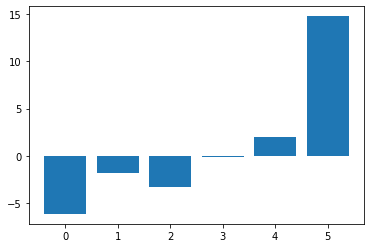

In [45]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0).fit(X_train_norm, y_train)
print(clf.score(X_test_norm, y_test))

importance = clf.coef_[0]
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

## Pause ratio only

In [46]:
X_train, X_test, y_train, y_test = train_test_split(features[['pause_ratio']], features['fake'], test_size=0.25, random_state=0)

scaler = MinMaxScaler()

X_train_norm = scaler.fit_transform(X_train)
X_test_norm = scaler.transform(X_test)

clf = LogisticRegression(random_state=0).fit(X_train_norm, y_train)
print(clf.score(X_test_norm, y_test))

0.7950635751682872


## N Pauses only

In [47]:
X_train, X_test, y_train, y_test = train_test_split(features[['n_pauses']], features['fake'], test_size=0.25, random_state=0)

scaler = MinMaxScaler()

X_train_norm = scaler.fit_transform(X_train)
X_test_norm = scaler.transform(X_test)

clf = LogisticRegression(random_state=0).fit(X_train_norm, y_train)
print(clf.score(X_test_norm, y_test))

0.6866118175018698


## Amplitude only

In [73]:
X_train, X_test, y_train, y_test = train_test_split(features[['amp_mean']], features['fake'], test_size=0.25, random_state=0)

scaler = MinMaxScaler()

X_train_norm = scaler.fit_transform(X_train)
X_test_norm = scaler.transform(X_test)

clf = LogisticRegression(random_state=0).fit(X_train_norm, y_train)
print(clf.score(X_test_norm, y_test))

0.8765893792071803


# Experiment 8: SVC

In [49]:
from sklearn import svm
X_train, X_test, y_train, y_test = train_test_split(features.iloc[:, 1:-1], features['fake'], test_size=0.25, random_state=0)

scaler = MinMaxScaler()

X_train_norm = scaler.fit_transform(X_train)
X_test_norm = scaler.transform(X_test)

clf = svm.SVC()
clf.fit(X_train_norm, y_train)
clf.score(X_test_norm, y_test)

0.9020194465220643

In [50]:
from sklearn.model_selection import GridSearchCV

param_grid = {'C': [0.1, 1, 10, 100, 1000], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf']} 
  
grid = GridSearchCV(clf, param_grid, refit = True, verbose = 3)
  
# fitting the model for grid search
grid.fit(X_train, y_train)

print(grid.best_params_)
  
print(grid.best_estimator_)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.687 total time=   0.3s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.723 total time=   0.3s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.698 total time=   0.3s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.717 total time=   0.3s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.714 total time=   0.3s
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.687 total time=   0.3s
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.714 total time=   0.3s
[CV 3/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.702 total time=   0.3s
[CV 4/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.719 total time=   0.3s
[CV 5/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.714 total time=   0.3s
[CV 1/5] END .....C=0.1, gamma=0.01, kernel=rbf;, score=0.699 total time=   0.3s
[CV 2/5] END .....C=0.1, gamma=0.01, kernel=rbf

In [51]:
clf = svm.SVC(C=1000, gamma=0.1, kernel='rbf')
clf.fit(X_train_norm, y_train)
clf.score(X_test_norm, y_test)

0.9020194465220643

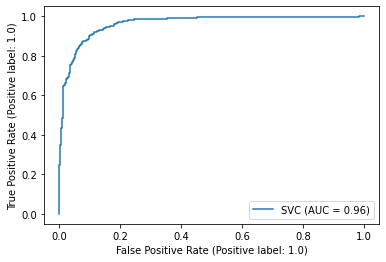

0.9041697147037308

In [52]:
from sklearn.metrics import RocCurveDisplay, f1_score

RocCurveDisplay.from_estimator(clf, X_test_norm, y_test)
plt.show()

y_pred = clf.predict(X_test_norm)
f1_score(y_test, y_pred)

# In the wild test
https://www.reddit.com/r/ElevenLabs/comments/122wrs0/biden_addresses_the_growing_skooma_use_in_skyrim/

Via TubeRipper https://tuberipper.com/279/

In [83]:
def run_cadence_test(data_input_path, flags = [1], silence_threshold = 0.005, low_pass_filter_cutoff = 10):
    
    ## PREPROCESS
    # Extract input files
    print('Extracting input files')
    all_wav_files, _ = extract_input_files(data_input_path)
    
    # Obtain sample rate
    sr = librosa.load(all_wav_files[0])[1]
    
    # Normalise amplitudes
    print('Normalizing amplitudes')
    normalized_audios = normalize_audio_amplitudes(all_wav_files)
    
    # Truncate silences
    print('Truncating silences')
    truncated_audios, start_ids, end_ids = truncate_silences(normalized_audios, silence_threshold, window_size=100)
    
    ## FEATURE ENGINEERING
    # Extract pauses 
    print('Extracting pauses')
    r_pauses, f_pauses = run_all_files(truncated_audios, flags, get_silence, silence_threshold)

    # Extract pause spreads
    print('Extracting pause spreads')
    r_silence_spreads, f_silence_spreads = run_all_files(truncated_audios, flags, get_silence_spread, silence_threshold)

    # Extract amplitude and derivative
    print('Extracting amplitude features')
    r_amps, f_amps = run_all_files(truncated_audios, flags, get_amplitude, silence_threshold, sample_rate=sr, cutoff_frequency=low_pass_filter_cutoff)
    
    ## FEATURE CONSOLIDATION
    # Create dataframe 
    print('Creating dataframe')
    features = pd.DataFrame({'file': all_wav_files, 
                         'pause_ratio':[item['ratio_pause_voiced'] for item in r_pauses + f_pauses], 
                         'pause_mean':[item['mean_of_silences'] for item in r_silence_spreads + f_silence_spreads], 
                         'pause_std':[item['spread_of_silences'] for item in r_silence_spreads + f_silence_spreads],  
                         'n_pauses':[item['n_pauses'] for item in r_silence_spreads + f_silence_spreads], 
                         'amp_deriv':[item['abs_deriv_amplitude'] for item in r_amps + f_amps],
                         'amp_mean':[item['mean_amplitude'] for item in r_amps + f_amps], 
                         'fake':flags})
    
    
    print('Complete')

    return features

test_features = run_cadence_test('test_biden')

Extracting input files
Normalizing amplitudes
Truncating silences
Extracting pauses
Extracting pause spreads
Extracting amplitude features
Creating dataframe
Complete


In [84]:
test_features

,file,pause_ratio,pause_mean,pause_std,n_pauses,amp_deriv,amp_mean,fake
0,test_biden/test_biden_audacity.wav,0.034836,0.004196,0.00616,8,5.421684e-07,0.133689,1


In [85]:
from sklearn import svm
X_train, X_test, y_train, y_test = train_test_split(features.iloc[:, 1:-1], features['fake'], test_size=0.25, random_state=0)

scaler = MinMaxScaler()

X_train_norm = scaler.fit_transform(X_train)
X_test_norm = scaler.transform(X_test)

clf = svm.SVC(C=1000, gamma=0.1, kernel='rbf')
clf.fit(X_train_norm, y_train)
clf.score(X_test_norm, y_test)

0.9020194465220643

In [86]:
X_new = test_features.iloc[:, 1:-1]
y_new = test_features['fake']
print(X_new)
print(y_new)

X_new_norm = scaler.transform(X_new)
print(X_new_norm)

   pause_ratio  pause_mean  pause_std  n_pauses     amp_deriv  amp_mean
0     0.034836    0.004196    0.00616         8  5.421684e-07  0.133689
0    1
Name: fake, dtype: int64
[[0.02884095 0.06504496 0.07353143 0.04117647 0.04992784 0.6368496 ]]


In [87]:
y_predicted_wild = clf.predict(X_new_norm)

In [88]:
y_predicted_wild

array([1.])